In [31]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.calibration import CalibratedClassifierCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import log_loss
from sklearn.externals import joblib
from nltk.corpus import stopwords
from scipy import sparse
import seaborn as sns
import pandas as pd
import numpy as np
import string
import pickle
import emoji
import nltk
import re

from collections import Counter
import seaborn as sns
import pandas as pd
import numpy as np
import re

import matplotlib.pyplot as mp
%matplotlib inline

#https://www.kaggle.com/tmjiang/stats

* Named entity recognition: Identify named "things" (entities) in text.

<img src="https://github.com/degravek/notebooks/blob/master/LLfigs/download.png?raw=True" width="500">

* The entities depend on the context (e.g., for yelp they might be food type, price, ambience, etc.).
* Real-world texts contain capitalization and context (part of speech) to identify entities.
* Goal is to identify entities in short website search queries to make search more focused.

# Get specialties, conditions, procedures

In [32]:
# Data from tables in Healthmaster, stack them all into one dataframe
df_spec = pd.read_csv('/Users/degrave/Healthgrades/search/data/production/new/new_specialty_gazette_cleaned.csv', encoding='ISO-8859-1')
df_cond = pd.read_csv('/Users/degrave/Healthgrades/search/data/production/new/new_condition_gazette_cleaned.csv', encoding='ISO-8859-1')
df_proc = pd.read_csv('/Users/degrave/Healthgrades/search/data/production/new/new_procedure_gazette_cleaned.csv', encoding='ISO-8859-1')
df_prov = pd.read_csv('/Users/degrave/Healthgrades/search/data/production/new/new_provider_gazette_cleaned.csv', encoding='ISO-8859-1')
df_faci = pd.read_csv('/Users/degrave/Healthgrades/search/data/production/new/new_facility_gazette_cleaned.csv', encoding='ISO-8859-1')

df_spec['target'] = 'specialty'
df_cond['target'] = 'condition'
df_proc['target'] = 'procedure'
df_prov['target'] = 'provider'
df_faci['target'] = 'facility'

df_prov = df_prov.sample(n=15000, random_state=0)
df_faci = df_faci.sample(n=15000, random_state=0)

df_spec.columns = ['Query', 'target']
df_cond.columns = ['Query', 'target']
df_proc.columns = ['Query', 'target']
df_prov.columns = ['Query', 'target']
df_faci.columns = ['Query', 'target']

In [33]:
df_spec.dropna(inplace=True)
df_spec.drop_duplicates(inplace=True)
df_spec.reset_index(drop=True, inplace=True)

df_cond.dropna(inplace=True)
df_cond.drop_duplicates(inplace=True)
df_cond.reset_index(drop=True, inplace=True)

df_proc.dropna(inplace=True)
df_proc.drop_duplicates(inplace=True)
df_proc.reset_index(drop=True, inplace=True)

df_prov.dropna(inplace=True)
df_prov.drop_duplicates(inplace=True)
df_prov.reset_index(drop=True, inplace=True)

df_faci.dropna(inplace=True)
df_faci.drop_duplicates(inplace=True)
df_faci.reset_index(drop=True, inplace=True)

In [34]:
# Encode the target variable
from sklearn.preprocessing import LabelEncoder

df = pd.concat([df_spec, df_cond, df_proc, df_prov, df_faci])

enc = LabelEncoder()

df['target'] = enc.fit_transform(df['target'])

In [10]:
df.sample(n=100).head()

,Query,target
7075,john richard schneider,3
6215,emergency obstetrics specialists doctor,4
6149,catalina armas bajwa,3
14453,david william hellerud,3
2805,hydrotherapy,2


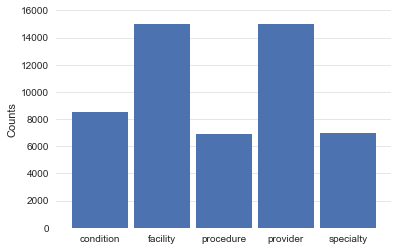

In [54]:
ax = df.groupby('target').count().reset_index().plot.bar(x='target', width=0.9, rot=0, legend=False)
ax.set_xticklabels(enc.classes_)
ax.set_facecolor('w')
ax.yaxis.grid(color=[0.9,0.9,0.9])
mp.ylim(0,16000)
mp.ylabel("Counts")
mp.xlabel("")
mp.show()

* Number of punctuation
* Number of characters (facilities are longer)
* Does query contain numbers?
* Average length of words in query
* Remove stop words
* Clean the text to remove punctuation

In [11]:
from nltk.corpus import stopwords

punctuation = '!"#?$%“”\'()’*+,—./:-;<=>@[\\]^_`{|}~…'
def numPunc(text):
    result = len([i for i in text if i in punctuation])
    return result

def numChars(text):
    result = len(text)
    return result

def minLength(text):
    r = ''.join([i for i in text if i not
                             in punctuation])
    result = min([len(i) for i in r.split()])
    return result

def maxLength(text):
    r = ''.join([i for i in text if i not
                             in punctuation])
    result = max([len(i) for i in r.split()])
    return result

def partSpeech(text):
    s = text.lower().split()
    pos = [part[1] for part in nltk.pos_tag(s)]
    pos = ' '.join(pos)
    return pos

def cleanText(text):
    result = text.lower().strip()
    result = re.sub(r'[^\x00-\x7F]+', ' ', result)
    result = re.sub('[\W]+', ' ', result)
    result = re.sub(r' +', ' ', result).strip()
    return result

def numNum(text):
    text = text.split()
    result = sum(i.isdigit() for i in text)
    return result

def contNum(text):
    text = text.split()
    result = sum(i.isdigit() for i in text)
    if result == 0: return 0
    else: return 1

def numTerms(text):
    result = len(text.split())
    return result

def avgLength(text):
    r = text.translate(str.maketrans('', '', string.punctuation))
    result = np.mean([len(i) for i in r.split()])
    return result

class ItemSelector(BaseEstimator, TransformerMixin):
    def __init__(self, key):
        self.key = key

    def fit(self, x, y=None):
        return self

    def transform(self, data_dict):        return data_dict[self.key]

In [163]:
# Clean the text
df['Query'] = df['Query'].apply(cleanText)

In [12]:
# Split into training and test sets
df_train, df_test = train_test_split(df, test_size=0.2, random_state=0)

<img src="https://github.com/degravek/notebooks/blob/master/LLfigs/download-1.png?raw=True" width="500">

In [ ]:
# Find best set of tuning parameters to use in classifier
param_grid = [{'tvec__ngram_range': [(1,2), (1,3), (1,5), (2,5), (3,5)],
               'tvec__use_idf': [True, False],
               'tvec__norm': ['l2', None],
               'tvec__sublinear_tf': [True, False],
               'clf__C': [0.1, 1, 10]}]

sc = StandardScaler()

#val_names = df.drop(['Query','target'], axis=1).columns

tvec = TfidfVectorizer(analyzer='char', stop_words=None, max_features=50000)

pipeline = Pipeline([
    ('tvec', tvec),
    ('clf', LogisticRegression())
])

grid_cv = GridSearchCV(pipeline, param_grid=param_grid, scoring='neg_log_loss', cv=5, n_jobs=-1, verbose=5)

grid_cv.fit(df_train['Query'], df_train['target'])

print(grid_cv.best_params_)
print(grid_cv.best_score_)

#{'clf__C': 1, 'tvec__ngram_range': (1, 5), 'tvec__norm': None, 'tvec__sublinear_tf': True, 'tvec__use_idf': False}
#-0.11718495646692882

<img src="https://github.com/degravek/notebooks/blob/master/LLfigs/download-2.png?raw=True" width="500" style="float: left;">
<img src="https://github.com/degravek/notebooks/blob/master/LLfigs/download-3.png?raw=True" width="500" style="float: left;">
<img src="https://github.com/degravek/notebooks/blob/master/LLfigs/download-4.png?raw=True" width="500" style="float: left;">

* When creating word vectors, we can remove stop words, normalize word vectors, etc.

In [ ]:
param_grid = {'clf__C': np.logspace(-1, 1, 10)}

tvec = TfidfVectorizer(analyzer='char', stop_words=None, max_features=50000, norm=None,
                                   ngram_range=(1,5), sublinear_tf=True, use_idf=False)

pipeline = Pipeline([
    ('tvec', tvec),
    ('clf', LogisticRegression())
])

grid_cv = GridSearchCV(pipeline, param_grid=param_grid, scoring='neg_log_loss', cv=5, n_jobs=-1, verbose=5)

grid_cv.fit(df_train['Query'], df_train['target'])

print(grid_cv.best_params_)
print(grid_cv.best_score_)

#{'clf__C': 1.291549665014884}
#-0.11664037661429921

* Recall: Of all specialties in our dataset, how many do we accurately classify?
* Precision: Of all *identified* specialties in our dataset, how many of them are actually specialties?
* F-score: Average of precision and recall.

In [25]:
# Make a prediction
predict = grid_cv.best_estimator_.predict(df_test['Query'])

print(classification_report(df_test['target'], predict))

             precision    recall  f1-score   support

          0       0.96      0.96      0.96      1695
          1       0.98      0.96      0.97      3038
          2       0.94      0.95      0.95      1365
          3       0.97      0.99      0.98      3012
          4       0.98      0.97      0.98      1371

avg / total       0.97      0.97      0.97     10481



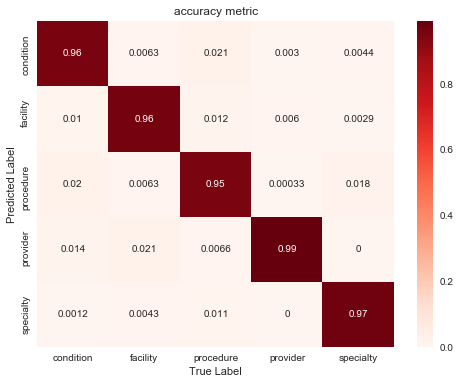

In [28]:
cm = confusion_matrix(df_test['target'], grid_cv.best_estimator_.predict(df_test['Query'])).T
cm = cm.astype('float')/cm.sum(axis=0)

fig, ax = mp.subplots(figsize=(8,6))

classes = ["condition", "facility", "procedure", "provider", "specialty"]

sns.heatmap(cm, annot=True, cmap='Reds');
mp.xlabel('True Label')
mp.ylabel('Predicted Label')
tick_marks = np.arange(len(classes))
mp.xticks(tick_marks + 0.5, classes)
mp.yticks(tick_marks + 0.75, classes[::-1])
mp.title('accuracy metric')

* Confusion matrix shows class accuracies from model predictions.
* Of all facilities in our dataset, we classify them correctly 96% of the time (provider 2% of the time).

## Save model

In [38]:
from sklearn.externals import joblib

tvec = TfidfVectorizer(strip_accents='unicode', analyzer='char', ngram_range=(2,5),
                       max_features=100000, norm='l2', stop_words=None, use_idf=True)

sc = StandardScaler()

val_names = df.drop(['Query','target'], axis=1).columns

pipeline = Pipeline([
    ('feat', FeatureUnion([
    ('c1', Pipeline([('sel1', ItemSelector('Query')), ('tvec', tvec)])),
    ('c2', Pipeline([('sel2', ItemSelector(val_names)), ('scale', sc)]))
    ])),
    ('clf', LogisticRegression(C=48.270709656031833, solver='newton-cg', multi_class='multinomial'))
])

pipeline.fit(df, df['target'])

dest = '/Users/degrave/Healthgrades/search/models/'
joblib.dump(pipeline, dest + 'ner25_pipeline.pkl')

Pipeline(memory=None,
     steps=[('feat', FeatureUnion(n_jobs=1,
       transformer_list=[('c1', Pipeline(memory=None,
     steps=[('sel1', ItemSelector(key='Query')), ('tvec', TfidfVectorizer(analyzer='char', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
       ...         random_state=None, solver='newton-cg', tol=0.0001, verbose=0,
          warm_start=False))])

In [ ]:
classes = ["condition", "procedure", "provider", "specialty"]

#-------- Baseline LR model (1) (1,1), (1,2), (1,3)
neg_log_loss, newton-cg, ovr
tvec = TfidfVectorizer(strip_accents='unicode', analyzer='word', ngram_range=(1,3),
                       max_features=None, norm=None, stop_words=None, use_idf=False)

             precision    recall  f1-score   support

          0       0.89      0.95      0.92      1563
          1       0.91      0.81      0.86       794
          2       0.94      0.97      0.96      1791
          3       0.87      0.67      0.76       260

avg / total       0.92      0.92      0.91      4408
0.95, 0.81, 0.97, 0.67

#-------- Baseline LR model (2) (1,1), (1,2), (1,3)
accuracy, sag, multinomial
tvec = TfidfVectorizer(strip_accents='unicode', analyzer='char', ngram_range=(1,3),
                       max_features=None, norm=None, stop_words='english', use_idf=True)

             precision    recall  f1-score   support

          0       0.93      0.95      0.94      1563
          1       0.89      0.88      0.88       794
          2       0.96      0.98      0.97      1791
          3       0.90      0.75      0.82       260

avg / total       0.93      0.93      0.93      4408
0.95, 0.88, 0.98, 0.75

#-------- Baseline LR model (3): combination of models (1) and (2)
accuracy, sag, ovr
tvec = TfidfVectorizer(strip_accents='unicode', analyzer='word', ngram_range=(1,3),
                       max_features=None, norm=None, stop_words=None, use_idf=False)
tvec = TfidfVectorizer(strip_accents='unicode', analyzer='char', ngram_range=(1,3),
                       max_features=None, norm=None, stop_words='english', use_idf=True)

             precision    recall  f1-score   support

          0       0.93      0.95      0.94      1563
          1       0.88      0.88      0.88       794
          2       0.96      0.98      0.97      1791
          3       0.92      0.75      0.82       260

avg / total       0.94      0.94      0.93      4408
accuracy = 0.95, 0.88, 0.98, 0.75

#-------- Baseline LR model (4) using only words (1,1), (2,2), (3,3), (1,2), (1,3)
accuracy, lbfgs, ovr
tvec = TfidfVectorizer(strip_accents='unicode', analyzer='word', ngram_range=(1,1),
                       max_features=None, norm='l1', stop_words=None, use_idf=False)

             precision    recall  f1-score   support

          0       0.90      0.95      0.92      1563
          1       0.90      0.84      0.87       794
          2       0.96      0.97      0.96      1791
          3       0.86      0.70      0.77       260

avg / total       0.92      0.92      0.92      4408
0.95, 0.84, 0.97, 0.7

#-------- Baseline LR model (5) using only chars (1,1), (2,2), (3,3), (1,2), (1,3)
accuracy, lbfgs, multinomial
tvec = TfidfVectorizer(strip_accents='unicode', analyzer='char', ngram_range=(3,3),
                       max_features=None, norm=None, stop_words=None, use_idf=True)

             precision    recall  f1-score   support

          0       0.94      0.95      0.94      1563
          1       0.89      0.88      0.88       794
          2       0.96      0.98      0.97      1791
          3       0.88      0.75      0.81       260

avg / total       0.93      0.94      0.94      4408
0.95, 0.88, 0.98, 0.75

#-------- Baseline LR model (6): combination of models (4) and (5)
accuracy, lbfgs, multinomial, {'C': 0.016297508346206444}
tvec = TfidfVectorizer(strip_accents='unicode', analyzer='word', ngram_range=(1,1),
                       max_features=None, norm='l1', stop_words=None, use_idf=False)
tvec = TfidfVectorizer(strip_accents='unicode', analyzer='char', ngram_range=(3,3),
                       max_features=None, norm=None, stop_words=None, use_idf=True)

             precision    recall  f1-score   support

          0       0.94      0.95      0.94      1563
          1       0.89      0.88      0.88       794
          2       0.96      0.98      0.97      1791
          3       0.88      0.75      0.81       260

avg / total       0.93      0.94      0.94      4408
0.95, 0.88, 0.98, 0.75

classes = ["condition", "facility", "procedure", "provider", "specialty"]

#-------- Baseline LR model (7): new data from database
accuracy, newton-cg, multinomial, {'C': 22.051307399030456}
tvec = TfidfVectorizer(strip_accents='unicode', analyzer='word', ngram_range=(1,1),
                       max_features=None, norm=None, stop_words=None, use_idf=False)

             precision    recall  f1-score   support

          0       0.90      0.95      0.93      1531
          1       0.99      0.95      0.97      2028
          2       0.90      0.83      0.86       830
          3       0.95      0.99      0.97      1996
          4       0.80      0.72      0.76       225

avg / total       0.94      0.94      0.94      6610
0.95, 0.95, 0.83, 0.99, 0.72

#-------- Baseline LR model (8): new data using only words (1,1), (1,2), (1,3)
accuracy, newton-cg, ovr, {'C': 87.084314976907237}
tvec = TfidfVectorizer(strip_accents='unicode', analyzer='word', ngram_range=(1,1),
                       max_features=None, norm='l2', stop_words=None, use_idf=False)

             precision    recall  f1-score   support

          0       0.91      0.94      0.93      1531
          1       0.99      0.95      0.97      2028
          2       0.89      0.85      0.87       830
          3       0.95      0.99      0.97      1996
          4       0.78      0.71      0.74       225

avg / total       0.94      0.94      0.94      6610
0.94, 0.95, 0.85, 0.99, 0.71

#-------- Baseline LR model (9): new data using only chars (1,1), (1,2), (1,3)
accuracy, newton-cg, ovr, {'C': 1.5072253093107555}
tvec = TfidfVectorizer(strip_accents='unicode', analyzer='char', ngram_range=(1,3),
                       max_features=None, norm=None, stop_words=None, use_idf=False)

             precision    recall  f1-score   support

          0       0.93      0.94      0.94      1531
          1       0.97      0.95      0.96      2028
          2       0.87      0.88      0.87       830
          3       0.96      0.97      0.96      1996
          4       0.86      0.78      0.82       225

avg / total       0.94      0.94      0.94      6610
0.94, 0.95, 0.88, 0.97, 0.78

#-------- *Baseline LR model (9) parameters using MLP neural network
512 (relu), do = 0.25, 256 (relu), 64 (relu), 8 (relu), 5 (softmax)
optimizer = optimizers.RMSprop(lr=0.00025, rho=0.9, epsilon=1e-08, decay=0.0)
loss='sparse_categorical_crossentropy', metrics=['accuracy']
epochs=10, batch_size=200, validation_split=0.2

          0       0.93      0.94      0.94      1531
          1       0.97      0.95      0.96      2028
          2       0.87      0.88      0.87       830
          3       0.96      0.97      0.96      1996
          4       0.86      0.78      0.82       225

avg / total       0.94      0.94      0.94      6610
0.94, 0.96, 0.84, 0.96, 0.80

#-------- Baseline LR model (10): new data, combination of models (8) and (9)
accuracy, newton-cg, ovr, {'C': 1.5072253093107555}
tvec = TfidfVectorizer(strip_accents='unicode', analyzer='word', ngram_range=(1,1),
                       max_features=None, norm='l2', stop_words=None, use_idf=False)
tvec = TfidfVectorizer(strip_accents='unicode', analyzer='char', ngram_range=(1,3),
                       max_features=None, norm=None, stop_words=None, use_idf=False)

             precision    recall  f1-score   support

          0       0.94      0.95      0.95      1531
          1       0.98      0.96      0.97      2028
          2       0.88      0.89      0.89       830
          3       0.96      0.98      0.97      1996
          4       0.85      0.78      0.81       225

avg / total       0.95      0.95      0.95      6610
0.95, 0.96, 0.89, 0.98, 0.78

#-------- *Baseline LR model (10) parameters using MLP neural network
512 (relu), do = 0.25, 256 (relu), 64 (relu), 8 (relu), 5 (softmax)
optimizer = optimizers.RMSprop(lr=0.00025, rho=0.9, epsilon=1e-08, decay=0.0)
loss='sparse_categorical_crossentropy', metrics=['accuracy']
epochs=10, batch_size=200, validation_split=0.2

             precision    recall  f1-score   support

          0       0.94      0.95      0.95      1531
          1       0.98      0.96      0.97      2028
          2       0.88      0.89      0.89       830
          3       0.96      0.98      0.97      1996
          4       0.85      0.78      0.81       225

avg / total       0.95      0.95      0.95      6610
0.95, 0.96, 0.9, 0.98, 0.73

#-------- Baseline LR model (11): using model (9) with pos tags
accuracy, newton-cg, ovr, {'C': 1.5072253093107555}
tvec = TfidfVectorizer(strip_accents='unicode', analyzer='char', ngram_range=(1,3),
                       max_features=None, norm=None, stop_words=None, use_idf=False)

             precision    recall  f1-score   support

          0       0.94      0.94      0.94      1531
          1       0.97      0.96      0.96      2028
          2       0.87      0.88      0.87       830
          3       0.96      0.98      0.97      1996
          4       0.85      0.78      0.81       225

avg / total       0.94      0.94      0.94      6610
0.94, 0.96, 0.88, 0.98, 0.78

In [ ]:
#df = pd.read_csv('/Users/degrave/Healthgrades/search/data/QueryReport.csv')

#df.rename(columns={"Internal Search Term Type": "SearchType", "HG Internal Search Term (11) (evar11)": "Query",
#                  "HG Internal Site Search (1) (event1)": "Event"}, inplace=True)

In [ ]:
figure, axes = mp.subplots(figsize=(10,8))
sns.heatmap(df[['numNum','contNum','numTerms','avgLength']].corr(), annot=True, vmax=1, linewidths=0.5)
mp.xticks(rotation=45)
mp.yticks(rotation=360)
mp.show()

#### Linear regression: Find the coefficients that produce the best fit line to the data

$y = \beta_0\, +\, \beta x$

#### Logistic regression: Find the coefficients which give the best accuracy on training data

$h = \frac{1}{1\, +\, e^{-z}}$

$z = \beta_0\, +\, \beta x_1\, +\, \beta_2 x_2\, +\, ...\, +\, \beta_n x_n$

<script>
  $(document).ready(function(){
    $('div.prompt').hide();
    $('div.back-to-top').hide();
    $('.breadcrumb').hide();
    $('.hidden-print').hide();
  });
</script>